<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0813.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [392]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
from keras.utils import to_categorical
import datetime
import random

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_500_acc(y_true, y_pred):
    delta = 500
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_1000_acc(y_true, y_pred):
    delta = 1000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_10000_acc(y_true, y_pred):
    delta = 10000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_5perc_acc(y_true, y_pred):
    delta = 0.05
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))

def soft_10perc_acc(y_true, y_pred):
    delta = 0.10
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))


def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values
            
class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))

periodic_logger_10 = PeriodicLogger(10) 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

## 성립 실험을 위한 시뮬레이션 데이터 생성

극단적인 power law 형태의 distribution을 시뮬레이션 한다.


<img src='https://miro.medium.com/max/2704/1*FLyS1quRikOyL_-dCA73yg.png' width='500'/>


In [393]:
def nafyc_func(row):
    code,real_yy,rate = row['CODE'],row['REAL_YY'],row['COM_RATE']
    return real_yy * rate + 99

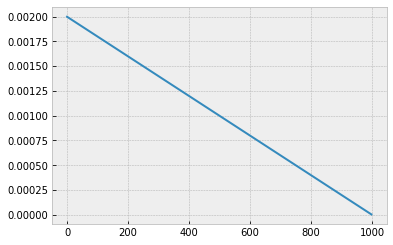

In [394]:
# random choice의 provability distribution
p = [1000-i for i in range(1000-1)]
p = p/np.sum(p)
plt.plot(p)

In [395]:
def create_samples(n_samples):
    rate_table = {}
    samples = []
    for i in range(1000,2520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,500))
      for j in range(count):
        real_yy = int((np.random.choice(range(1,1000),p=p)/10)**6/100000 + 100)
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]
        samples.append([code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CODE','REAL_YY','COM_RATE'])

In [396]:
dataset = create_samples(n_samples=100)
dataset['NAFYC'] = dataset.apply(nafyc_func, axis=1)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,555,0.48,365.40
1,1000,880651,0.48,422811.48
2,1000,921006,0.48,442181.88
3,1000,3485,0.48,1771.80
4,1000,221743,0.48,106535.64
...,...,...,...,...
379265,2519,141,0.60,183.60
379266,2519,39846,0.60,24006.60
379267,2519,309,0.60,284.40
379268,2519,224264,0.60,134657.40


## 성립 데이터 EDA

In [397]:
dataset = dataset.astype({"CODE": object})
dataset = dataset.astype({"COM_RATE": object})
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CODE,object,379270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1520.0,2217.00,499.0
REAL_YY,int64,379270.0,0,360557.693429,995173.849469,100.0,160.0,6557.0,160137.000,9940249.00,NaN,NaN,NaN
COM_RATE,object,379270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.0,0.13,6667.0
NAFYC,float64,379270.0,0,181667.674308,585547.139825,100.0,189.0,2567.8,62703.655,9723328.56,NaN,NaN,NaN


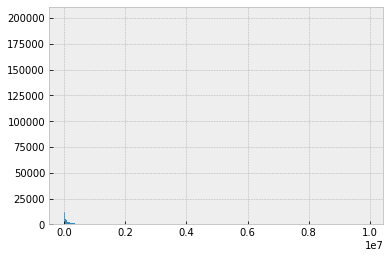

In [398]:
# 극단적인 power law 형태 확인  
dataset['REAL_YY'].hist(bins=1000)

## 데이터 전처리

In [440]:
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.layers.experimental import RandomFourierFeatures

def data_preprocess(ds1):
  # zscore norm
  ds = ds1.copy()
  ds = ds.astype({"COM_RATE": float})
  dst = ds[['REAL_YY','COM_RATE']]

  _mean = dst.mean(axis=0)
  _std = dst.std(axis=0)

  dst = dst - _mean
  dst /= _std

  ds.update(dst)
  ds['ft1'] = ds['REAL_YY']*ds['COM_RATE']
  ds = ds.astype({"COM_RATE": object})
  # code mapping
  code_mapping = EmbeddingMapping(ds['CODE'])
  ds = ds.assign(code_mapping=ds['CODE'].apply(code_mapping.get_mapping))

  rate_mapping = EmbeddingMapping(ds['COM_RATE'])
  ds = ds.assign(rate_mapping=ds['COM_RATE'].apply(rate_mapping.get_mapping))

  # trainset과 validationset 나누고... 기타 정리

  X_train_org, X_val_org, Y_train, Y_val = train_test_split(ds[['REAL_YY','ft1','code_mapping','rate_mapping']],
      ds['NAFYC'], test_size=0.1, random_state=0)

  # 학습 대상 변수만 선택
  X_train_continuous = X_train_org[['REAL_YY','ft1']]
  X_train_categorical = X_train_org[['code_mapping','rate_mapping']]

  X_val_continuous  = X_val_org[['REAL_YY','ft1']]
  X_val_categorical = X_val_org[['code_mapping','rate_mapping']]

  ######################### polynomial
  n = 3
  trX_expanded = np.expand_dims(X_train_continuous, axis=1)
  poly = PolynomialFeatures(n)
  X_train_continuous = poly.fit_transform(X_train_continuous)
  X_val_continuous = poly.fit_transform(X_val_continuous)
  ###########################

  return X_train_continuous,X_train_categorical,X_val_continuous,X_val_categorical,Y_train, Y_val

X_train_continuous,X_train_categorical,X_val_continuous,X_val_categorical,Y_train, Y_val = data_preprocess(dataset)

## Network 구성

In [441]:
def model_build(X_train_continuous,X_train_categorical): 
    # Define the embedding input
    code_input = Input(shape=(X_train_categorical.shape[1],), dtype='int32') 
    output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
    code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
    code_embedings = keras.layers.Reshape((output_dim*X_train_categorical.shape[1],))(code_embedings)

    # Define the continuous variables input (just like before)
    continuous_input = Input(shape=(X_train_continuous.shape[1], ))

    # Concatenate continuous and embeddings inputs
    all_input = keras.layers.concatenate([continuous_input, code_embedings])
    print(all_input)

    # Define the model
    dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
    dense2 = Dense(5, activation='relu')(dense1)
    predictions = Dense(1)(dense2)

    # Note using the input object 'area_input' not 'area_embeddings'
    model = Model(inputs=[continuous_input, code_input], outputs=predictions)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10perc_acc,soft_500_acc,soft_1000_acc,soft_10000_acc,r2])
    model.summary()
    return model

model = model_build(X_train_continuous,X_train_categorical)

Tensor("concatenate_97/concat:0", shape=(None, 138), dtype=float32)
Model: "functional_210"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_196 (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding_98 (Embedding)        (None, 2, 64)        97344       input_196[0][0]                  
__________________________________________________________________________________________________
input_197 (InputLayer)          [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_98 (Reshape)            (None, 128)          0           embedding_98[0][0]               
_________________

## 학습

Epoch: 10 - {'loss': 2146553472.0, 'soft_5perc_acc': 0.09805193543434143, 'soft_10perc_acc': 0.1467706859111786, 'soft_500_acc': 0.2649524509906769, 'soft_1000_acc': 0.3090682923793793, 'soft_10000_acc': 0.5861089825630188, 'r2': 0.993854284286499, 'val_loss': 431469600.0, 'val_soft_5perc_acc': 0.1624656468629837, 'val_soft_10perc_acc': 0.22654373943805695, 'val_soft_500_acc': 0.2014254629611969, 'val_soft_1000_acc': 0.25082290172576904, 'val_soft_10000_acc': 0.6800129413604736, 'val_r2': 0.9987106323242188}
Epoch: 20 - {'loss': 27136268.0, 'soft_5perc_acc': 0.3258124887943268, 'soft_10perc_acc': 0.3796207308769226, 'soft_500_acc': 0.31307652592658997, 'soft_1000_acc': 0.4780850112438202, 'soft_10000_acc': 0.9628289341926575, 'r2': 0.9999205470085144, 'val_loss': 41434364.0, 'val_soft_5perc_acc': 0.33316048979759216, 'val_soft_10perc_acc': 0.3868390619754791, 'val_soft_500_acc': 0.3534184992313385, 'val_soft_1000_acc': 0.5311194062232971, 'val_soft_10000_acc': 0.9578514099121094, 'val_

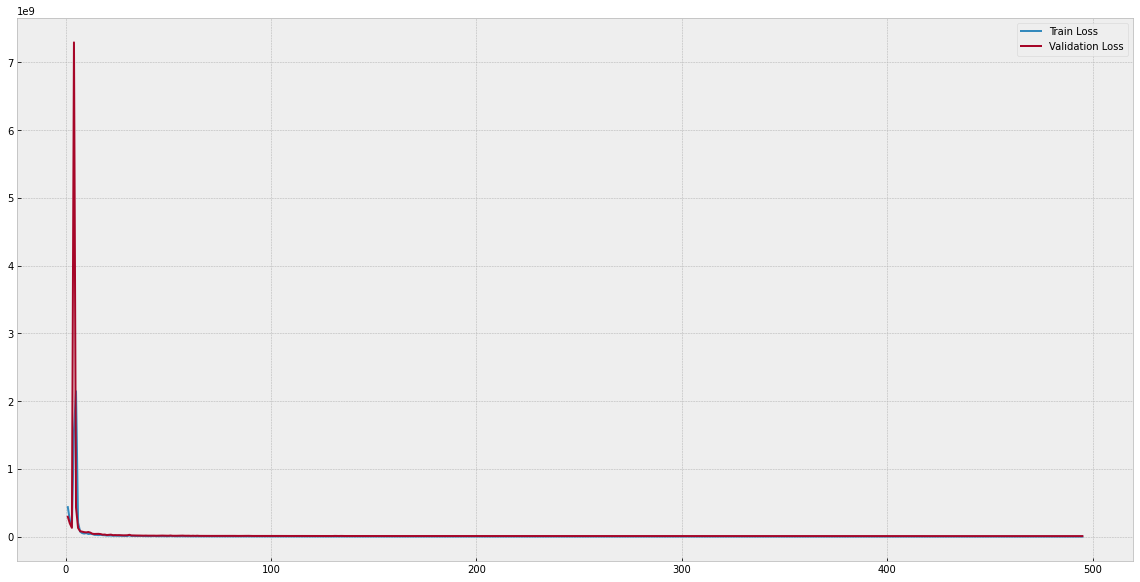

In [442]:
def train_model(model,X_train_continuous, X_train_categorical,X_val_continuous, X_val_categorical,Y_train, Y_val, epochs = 200):
  # Note continuous and categorical columns are inserted in the same order as defined in all_inputs
  history = model.fit([X_train_continuous, X_train_categorical], Y_train, 
            epochs=epochs, batch_size=10000, 
            callbacks=[periodic_logger_10], verbose=0,
            validation_data=([X_val_continuous, X_val_categorical], Y_val))
  # Plot the train/validation loss values
  plt.figure(figsize=(20,10))
  _loss = history.history['loss'][5:]
  _val_loss = history.history['val_loss'][5:]

  train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
  val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

  _ = plt.legend(handles=[train_loss_plot, val_loss_plot])
  return model

train_model(model,X_train_continuous, X_train_categorical,X_val_continuous, X_val_categorical,Y_train,Y_val, epochs = 500)

## 전략의 변경

상대오차 (5%, 10%)는 70%를 넘기지 못하면서, 절대오차 (10000원)은 99% 이상을 보이는 현상은 NAFYC가 극단적인 power law distribution을 갖기 떄문이다.
따라서, 전체 데이터를 한번에 학습하는 것이 아니라 구간별로 나누어 학습하는 방법으로 전략을 변경한다.
이를 통해, 각 구간에서 극단적인 power law 분포를 회피하도록 한다.

## 4개 구간별 학습

1구간 : 100만원 이상<br>
2구간 : 10 ~ 100만원<br>
3구간 : 1 ~ 10만원<br>
4구간 : 1만원이하<br>



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb413fea048>,
      dtype=object)

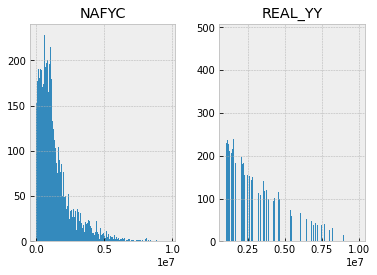

In [443]:
# 1구간
ds_e6 = dataset[dataset['REAL_YY'] > 1000000]
ds_e6.hist(bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb44f447748>,
      dtype=object)

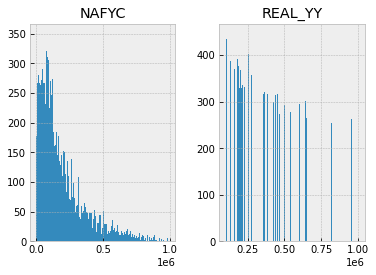

In [444]:
# 2구간
ds_e5 = dataset[(dataset['REAL_YY'] > 100000) & (dataset['REAL_YY'] <= 1000000)]
ds_e5.hist(bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3f916bb70>,
      dtype=object)

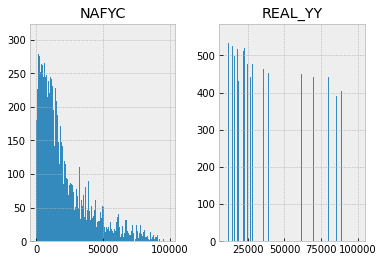

In [459]:
# 3구간
ds_e4 = dataset[(dataset['REAL_YY'] > 10000) & (dataset['REAL_YY'] <= 100000)]
ds_e4.hist(bins=1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3ea5a3550>,
      dtype=object)

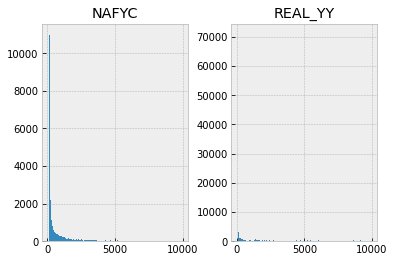

In [462]:
# 4구간
ds_e1 = dataset[dataset['REAL_YY'] <= 10000]
ds_e1.hist(bins=1000)

In [447]:
print('1구간(100만이상) 비율:',ds_e6.shape[0]/dataset.shape[0])
print('2구간( 10만이상) 비율:',ds_e5.shape[0]/dataset.shape[0])
print('3구간(  1만이상) 비율:',ds_e4.shape[0]/dataset.shape[0])
print('4구간(  1만이하) 비율:',ds_e1.shape[0]/dataset.shape[0])

1구간(100만이상) 비율: 0.10186938065230575
2구간( 10만이상) 비율: 0.18617080180346454
3구간(  1만이상) 비율: 0.18247686344820313
4구간(  1만이하) 비율: 0.5294829540960265


Tensor("concatenate_100/concat:0", shape=(None, 138), dtype=float32)
Model: "functional_216"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_202 (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding_101 (Embedding)       (None, 2, 64)        96768       input_202[0][0]                  
__________________________________________________________________________________________________
input_203 (InputLayer)          [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_101 (Reshape)           (None, 128)          0           embedding_101[0][0]              
________________

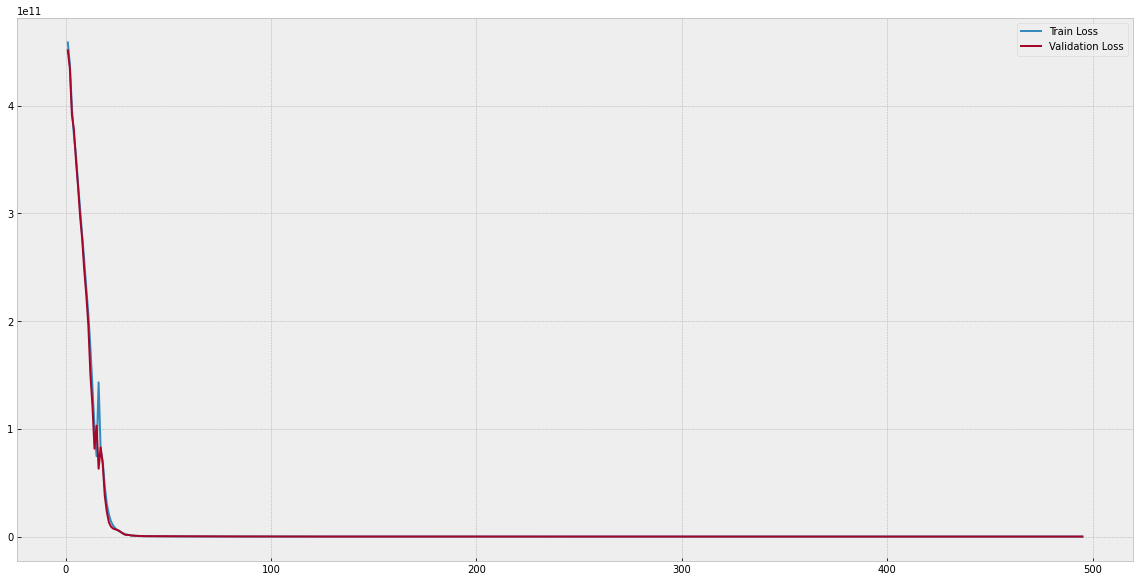

In [450]:
# 1구간 학습

X_train_continuous,X_train_categorical,X_val_continuous_e6,X_val_categorical_e6,Y_train, Y_val_e6 = data_preprocess(ds_e6)
model_e6 = model_build(X_train_continuous,X_train_categorical)
model_build_e6 = train_model(model_e6,X_train_continuous,X_train_categorical,X_val_continuous_e6,X_val_categorical_e6,Y_train, Y_val_e6,epochs = 500)

Tensor("concatenate_102/concat:0", shape=(None, 138), dtype=float32)
Model: "functional_220"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_206 (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding_103 (Embedding)       (None, 2, 64)        96960       input_206[0][0]                  
__________________________________________________________________________________________________
input_207 (InputLayer)          [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_103 (Reshape)           (None, 128)          0           embedding_103[0][0]              
________________

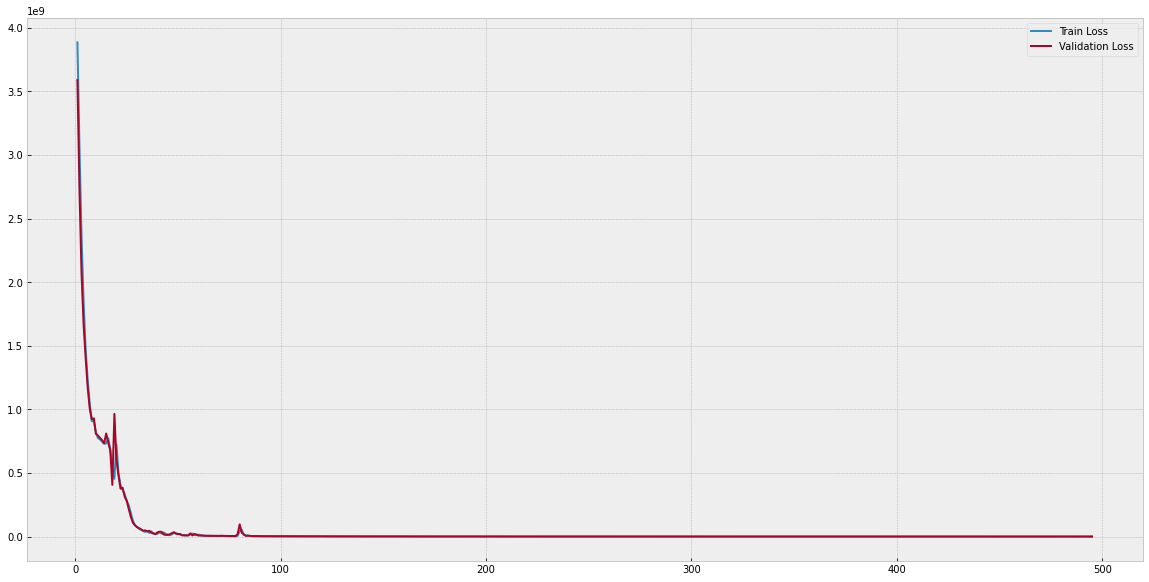

In [452]:
# 2구간 ( 10만원 이상)의 학습
X_train_continuous,X_train_categorical,X_val_continuous_e5,X_val_categorical_e5,Y_train, Y_val_e5 = data_preprocess(ds_e5)
model_e5 = model_build(X_train_continuous,X_train_categorical)
model_build_e5 = train_model(model_e5,X_train_continuous,X_train_categorical,X_val_continuous_e5,X_val_categorical_e5,Y_train, Y_val_e5,epochs = 500)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Tensor("concatenate_108/concat:0", shape=(None, 138), dtype=float32)
Model: "functional_232"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_218 (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding_109 (Embedding)       (None, 2, 64)        97088       input_218[0][0]                  
__________________________________________________________________________________________________
input_219 (InputLayer)          [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_109 (Reshape)           (None, 128)          0           embedding_109[0][0]              
________________

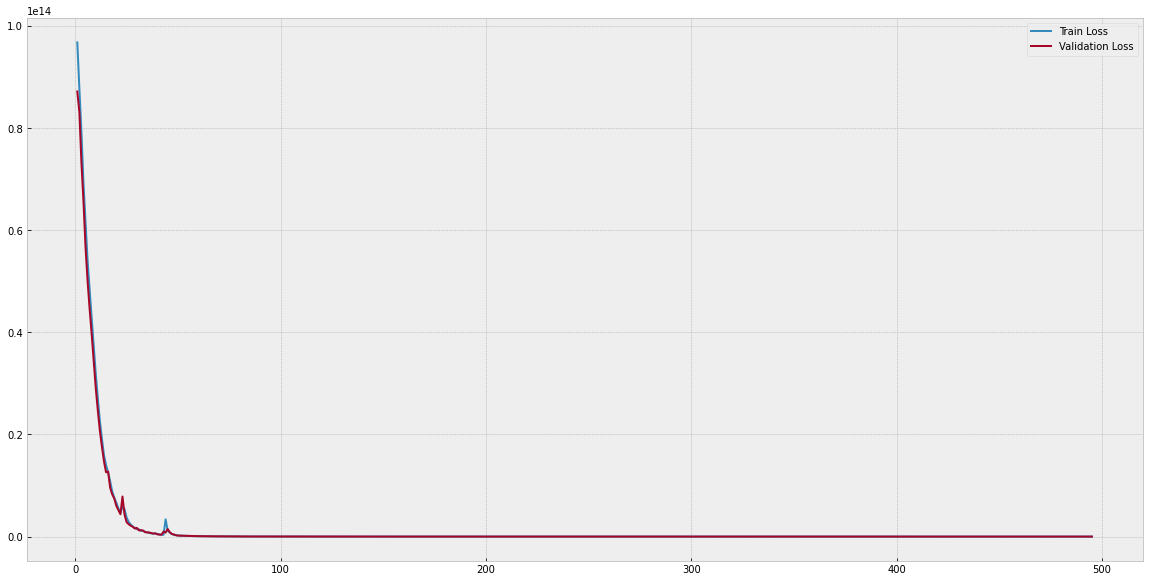

In [460]:
# 3구간 ( 1만원 이상)의 학습
ds_e4['NAFYC'] = ds_e4['NAFYC'] * 1000
X_train_continuous,X_train_categorical,X_val_continuous_e4,X_val_categorical_e4,Y_train, Y_val_e4 = data_preprocess(ds_e4)
model_e4 = model_build(X_train_continuous,X_train_categorical)
model_build_e4 = train_model(model_e4,X_train_continuous,X_train_categorical,X_val_continuous_e4,X_val_categorical_e4,Y_train, Y_val_e4,epochs = 500)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Tensor("concatenate_110/concat:0", shape=(None, 138), dtype=float32)
Model: "functional_236"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_222 (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding_111 (Embedding)       (None, 2, 64)        97344       input_222[0][0]                  
__________________________________________________________________________________________________
input_223 (InputLayer)          [(None, 10)]         0                                            
__________________________________________________________________________________________________
reshape_111 (Reshape)           (None, 128)          0           embedding_111[0][0]              
________________

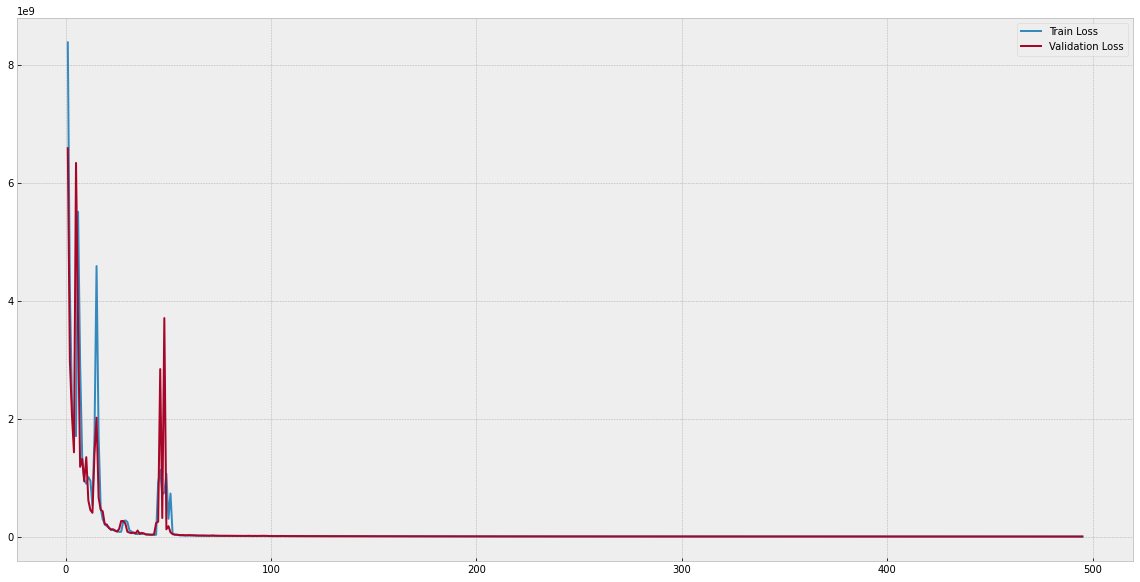

In [463]:
# 4구간 ( 1만원 이하)의 학습

# 전처리 추가
ds_e1['NAFYC'] = ds_e1['NAFYC'] * 1000

X_train_continuous,X_train_categorical,X_val_continuous_e1,X_val_categorical_e1,Y_train, Y_val_e1 = data_preprocess(ds_e1)
model_e1 = model_build(X_train_continuous,X_train_categorical)
model_build_e1 = train_model(model_e1,X_train_continuous,X_train_categorical,X_val_continuous_e1,X_val_categorical_e1,Y_train, Y_val_e1,epochs = 500)

## 4개 구간 전체적인 Evaluation

In [464]:
def range_eveluation(rng,X_val_continuous, X_val_categorical,Y_val,model,adjust_weight=1.0):
    df = pd.DataFrame(Y_val,columns=['NAFYC'])
    df['NAFYC'] = df['NAFYC'] * adjust_weight
    print (str(rng) + "구간 평균 NAFYC: %d" % df['NAFYC'].mean())
    # Add a column for the model's predicted values
    df['pred'] = model.predict([X_val_continuous, X_val_categorical])
    df['pred'] = df['pred'] * adjust_weight
    # Calculate the difference between the predicted and the actual price
    df['diff'] = df['pred'] - df['NAFYC']
    # Calculate the absolute difference between the predicted and the actual price
    df['abs_diff'] = np.abs(df['diff'])
    # Calculate the percentage of the difference from the actual price
    df['%diff'] = 100 * (df['diff'] / df['NAFYC'])
    # Calculate the absolute percentage difference from the actual price
    df['abs_%diff'] = np.abs(df['%diff'])
    # Calculate the mean and std. of the diff field
    diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
    print(str(rng) + "구간 오차평균 ({mean}) 표준편차 {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))
    print("5% 오차내 정확도 ",1- df[df['abs_%diff'] > 5]['abs_%diff'].count()/df['abs_%diff'].count())
    return df

df1 = range_eveluation(1,X_val_continuous_e6, X_val_categorical_e6,Y_val_e6,model_build_e6)    
df1.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

1구간 평균 NAFYC: 1363567
1구간 오차평균 (-422.62) 표준편차 4850.81.
5% 오차내 정확도  0.9790372670807453


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
108236,87069.58,246645.859375,159576.279375,159576.279375,183.274433,183.274433
18963,70418.59,120109.960938,49691.370938,49691.370938,70.565700,70.565700
155870,10985.99,18723.103516,7737.113516,7737.113516,70.427094,70.427094
234463,76919.52,123902.640625,46983.120625,46983.120625,61.080881,61.080881
139531,41427.08,30985.082031,-10441.997969,10441.997969,-25.205730,25.205730
247994,36006.09,44831.601562,8825.511563,8825.511563,24.511163,24.511163
217396,60735.50,46613.277344,-14122.222656,14122.222656,-23.252007,23.252007
245349,13018.66,15831.791016,2813.131016,2813.131016,21.608453,21.608453
245390,13686.72,16623.185547,2936.465547,2936.465547,21.454852,21.454852
63620,257822.49,306536.937500,48714.447500,48714.447500,18.894569,18.894569


In [465]:
df2 = range_eveluation(2,X_val_continuous_e5, X_val_categorical_e5,Y_val_e5,model_build_e5)    
df2.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

2구간 평균 NAFYC: 191930
2구간 오차평균 (-18.3) 표준편차 842.0.
5% 오차내 정확도  0.9803144030590568


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
103588,8623.26,43.188839,-8580.071161,8580.071161,-99.499159,99.499159
103627,7636.30,43.188839,-7593.111161,7593.111161,-99.434427,99.434427
93022,7405.06,43.188839,-7361.871161,7361.871161,-99.416766,99.416766
245708,6594.34,43.188839,-6551.151161,6551.151161,-99.345062,99.345062
217558,6472.39,43.188839,-6429.201161,6429.201161,-99.332722,99.332722
245517,6352.35,43.188839,-6309.161161,6309.161161,-99.320112,99.320112
267230,6293.03,43.188839,-6249.841161,6249.841161,-99.313704,99.313704
245598,6117.91,43.188839,-6074.721161,6074.721161,-99.294059,99.294059
267400,5946.93,43.188839,-5903.741161,5903.741161,-99.273762,99.273762
155828,5835.21,43.188839,-5792.021161,5792.021161,-99.259858,99.259858


In [466]:
df3 = range_eveluation(3,X_val_continuous_e4, X_val_categorical_e4,Y_val_e4,model_build_e4,adjust_weight=0.001)    
df3.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

3구간 평균 NAFYC: 20151
3구간 오차평균 (0.39) 표준편차 22.59.
5% 오차내 정확도  0.9979771709290565


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
245605,1097.94,1357.368774,259.428774,259.428774,23.628684,23.628684
262966,2020.70,2346.374268,325.674268,325.674268,16.116903,16.116903
18935,268.62,298.354736,29.734736,29.734736,11.069442,11.069442
18885,222.26,245.844055,23.584055,23.584055,10.611021,10.611021
170178,816.29,880.922668,64.632668,64.632668,7.917856,7.917856
108243,251.77,270.687714,18.917714,18.917714,7.513887,7.513887
155912,1085.11,1160.490601,75.380601,75.380601,6.946817,6.946817
60490,418.11,446.831207,28.721207,28.721207,6.869295,6.869295
48626,574.36,609.607056,35.247056,35.247056,6.136753,6.136753
300928,516.64,547.410645,30.770645,30.770645,5.955916,5.955916


In [467]:
df4 = range_eveluation(4,X_val_continuous_e1, X_val_categorical_e1,Y_val_e1,model_build_e1,adjust_weight=0.001)    
df4.sort_values(by=['abs_%diff'], axis=0, ascending=False).head(10)

4구간 평균 NAFYC: 770
4구간 오차평균 (-0.08) 표준편차 1.87.
5% 오차내 정확도  0.9907877701424161


,NAFYC,pred,diff,abs_diff,%diff,abs_%diff
19007,116.84,137.468250,20.628250,20.628250,17.655127,17.655127
49012,116.41,134.633688,18.223688,18.223688,15.654744,15.654744
267141,119.11,137.346172,18.236172,18.236172,15.310362,15.310362
155807,125.60,144.543688,18.943687,18.943687,15.082554,15.082554
217437,116.41,133.434797,17.024797,17.024797,14.624858,14.624858
108197,126.22,143.159328,16.939328,16.939328,13.420479,13.420479
49042,112.97,127.997914,15.027914,15.027914,13.302571,13.302571
245609,114.04,128.856391,14.816391,14.816391,12.992275,12.992275
234277,126.85,142.465766,15.615766,15.615766,12.310418,12.310418
234332,127.49,142.137766,14.647766,14.647766,11.489345,11.489345


In [468]:
df = pd.concat([df1,df2,df3,df4])
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("전체 구간 오차평균 ({mean}) 표준편차 {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))
print("1% 오차내 정확도 ",1- df[df['abs_%diff'] > 1]['abs_%diff'].count()/df['abs_%diff'].count())
print("5% 오차내 정확도 ",1- df[df['abs_%diff'] > 5]['abs_%diff'].count()/df['abs_%diff'].count())
print("10% 오차내 정확도 ",1- df[df['abs_%diff'] > 10]['abs_%diff'].count()/df['abs_%diff'].count())


전체 구간 오차평균 (-46.43) 표준편차 1595.25.
1% 오차내 정확도  0.9458447584897701
5% 오차내 정확도  0.9889527525838431
10% 오차내 정확도  0.9965197215777262


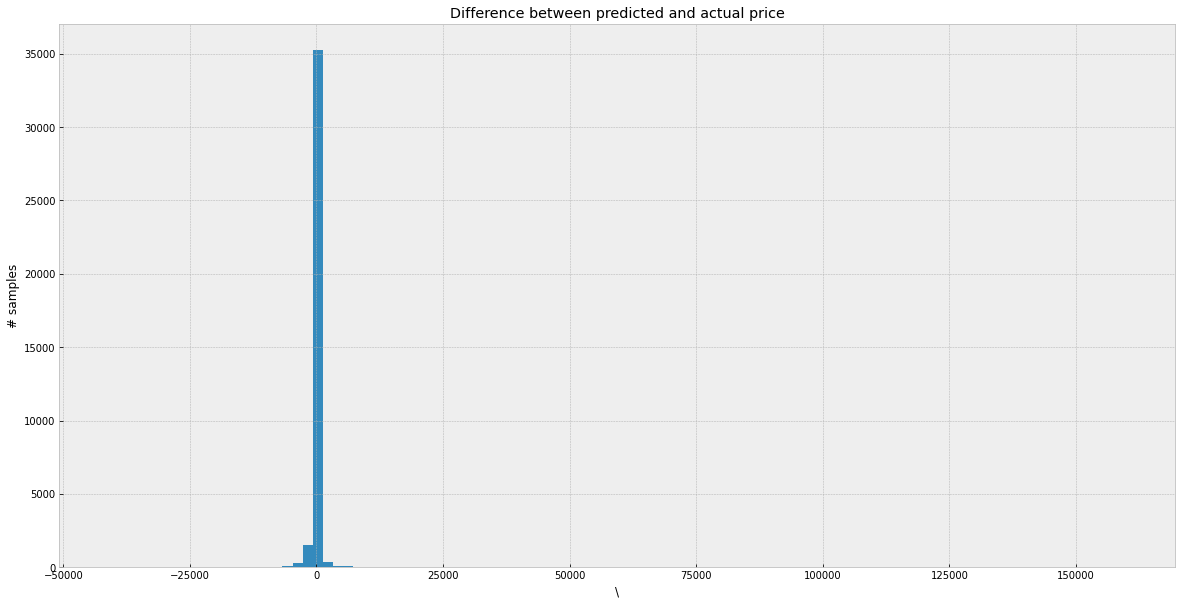

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC
108236,246645.859375,159576.279375,159576.279375,183.274433,183.274433,1417,8697058,0.01,87069.58
103588,43.188839,-8580.071161,8580.071161,-99.499159,99.499159,1398,426213,0.02,8623.26
103627,43.188839,-7593.111161,7593.111161,-99.434427,99.434427,1398,376865,0.02,7636.30
93022,43.188839,-7361.871161,7361.871161,-99.416766,99.416766,1357,365303,0.02,7405.06
245708,43.188839,-6551.151161,6551.151161,-99.345062,99.345062,1987,649534,0.01,6594.34
217558,43.188839,-6429.201161,6429.201161,-99.332722,99.332722,1875,637339,0.01,6472.39
245517,43.188839,-6309.161161,6309.161161,-99.320112,99.320112,1987,625335,0.01,6352.35
267230,43.188839,-6249.841161,6249.841161,-99.313704,99.313704,2070,619403,0.01,6293.03
245598,43.188839,-6074.721161,6074.721161,-99.294059,99.294059,1987,601891,0.01,6117.91
267400,43.188839,-5903.741161,5903.741161,-99.273762,99.273762,2070,584793,0.01,5946.93


In [469]:
# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_%diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [470]:
dataset[dataset['CODE']==1769]

,CODE,REAL_YY,COM_RATE,NAFYC
191084,1769,475,0.92,536.00
191085,1769,3666350,0.92,3373141.00
191086,1769,229378,0.92,211126.76
191087,1769,372978,0.92,343238.76
191088,1769,321965,0.92,296306.80
...,...,...,...,...
191293,1769,400906,0.92,368932.52
191294,1769,485636,0.92,446884.12
191295,1769,2133522,0.92,1962939.24
191296,1769,125,0.92,214.00


## Non-linearity 대응을 위한 polynomial Regression 적용
https://medium.com/analytics-vidhya/polynomial-regression-with-keras-ef1797b39b88